In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil
from math import sqrt
import sqlite3
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools

In [2]:
def genData(mongoid, conn, cursor, impute=True, freq='daily', standardize=False):
    '''
    Generate a timeseries dataframe for ARIMA modelling.
    mongoid: str. string of mongodb id.
    conn: sqlite3 connection.
    cursor: sqlite3 cursor.
    impute:
    freq:
    actualrevcount:
    standardize
    Example:
    product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, 
       freq='daily', actualrevcount=20, standardize=True)
    '''
    initial = routines.sqlToDf(conn, cursor)
    allproduct = initial.selectReview3(mongoid, impute=impute)
    product = routines.tsSalesRateSentiment(allproduct, freq=freq, standardize=standardize)
    return product

In [3]:
# Jeffrey Yau
def tsplot(y, title, lags=None, figsize=(12, 8)):
    '''
    Examine the patterns of ACF and PACF, along with the time series
    plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [4]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
def detpq(data, par=range(0,6)):
    '''
    Determine values of p & q that minimize AICc

    par: python range. parameter
    data: numpy ndarray or pandas series.
        y_train['Sales'].values
    sdfa
    '''
    # Define the p and q parameters to take any value between 0 and 2
    p = q = par
    
    # Generate all different combinations of p and q triplets
    pq = list(itertools.product(p, q))

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    AIC_list = pd.DataFrame({}, columns=['param','AIC'])
    for param in pq:
        try:
            mod = sm.tsa.VARMAX(data, order=param)
            results = mod.fit()
            #print('ARIMA{} - AIC:{}'.format(param, 
            #    sm.tools.eval_measures.aicc(results.llf, 
            #        results.nobs, results.df_model)))
            temp = pd.DataFrame([[ param ,  results.bic ]], 
                columns=['param', 'AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)
            del temp
        except:
            continue

    AIC_list = AIC_list.sort_values(by='AIC').reset_index()
    AIC_list.columns = ['index', 'param', 'BIC']
    return AIC_list

In [5]:
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

In [6]:
# result reproducibility
np.random.seed(42)

<br>pilihan:
>     2 data di database product.db dgn review > 900:
>         5aa2ad7735d6d34b0032a795
>         5aa39533ae1f941be7165ecd
>     cluster 3
>         5a93e8768cbad97881597597
>         or 
>         5a95d7ae35d6d33d3fea56ff
>     cluster 1
>         5aa2c35e35d6d34b0032a796
>     cluster 2 
>         5a92474635d6d32207bcd343
</br>

## <font color=blue> 1. Mongodb ID: 5aa2ad7735d6d34b0032a795 </font>

In [9]:
prod1 = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=False, freq='daily', standardize=False)

In [10]:
prod1.head()

,Sales,rating,ovsentiment
date,,,
2016-11-06,2,3.500000,0.500000
2016-11-07,1,5.000000,1.000000
2016-11-08,0,0.000000,0.000000
2016-11-09,0,0.000000,0.000000
2016-11-10,3,4.666667,0.333333


In [11]:
prod1 = prod1[prod1['Sales'] != 0]

In [12]:
prod1.shape

(332, 3)

In [13]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['Sales'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-6.673059e+00,Test Statistic
1,7.649768e-08,p-value
2,3.000000e+00,#Lags Used
3,3.280000e+02,Number of Observations Used
4,-3.986639e+00,Critical value for 1%
5,-3.423961e+00,Critical value for 5%
6,-3.134970e+00,Critical value for 10%


In [14]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['rating'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-20.585629,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,331.000000,Number of Observations Used
4,-3.986384,Critical value for 1%
5,-3.423838,Critical value for 5%
6,-3.134898,Critical value for 10%


In [15]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['ovsentiment'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-6.967397e+00,Test Statistic
1,1.674369e-08,p-value
2,3.000000e+00,#Lags Used
3,3.280000e+02,Number of Observations Used
4,-3.986639e+00,Critical value for 1%
5,-3.423961e+00,Critical value for 5%
6,-3.134970e+00,Critical value for 10%


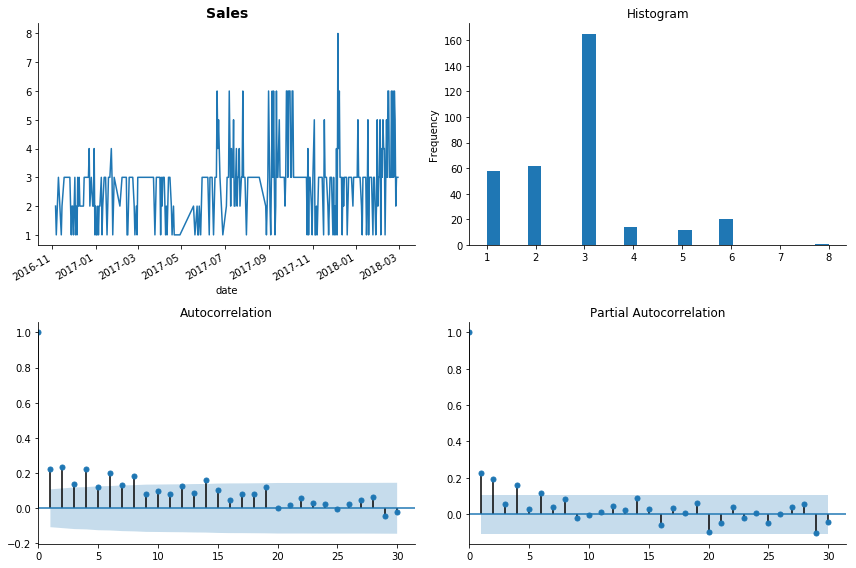

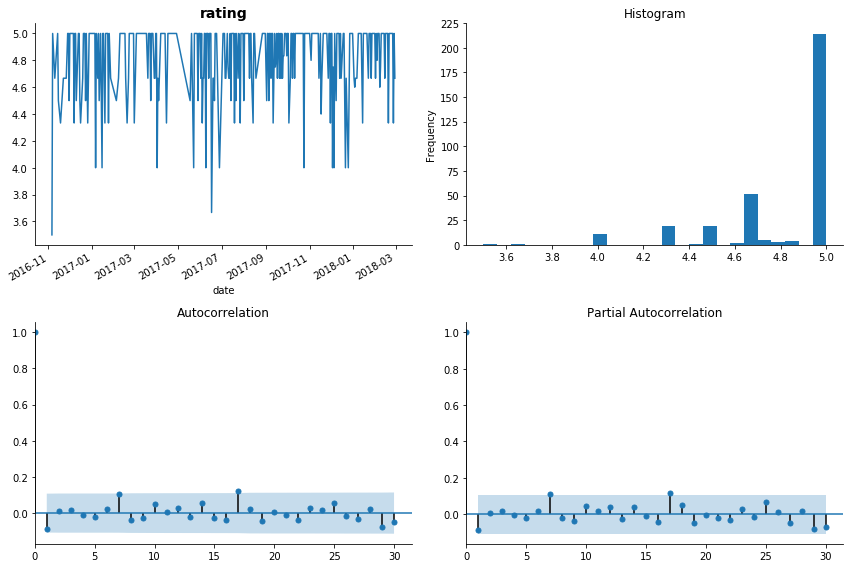

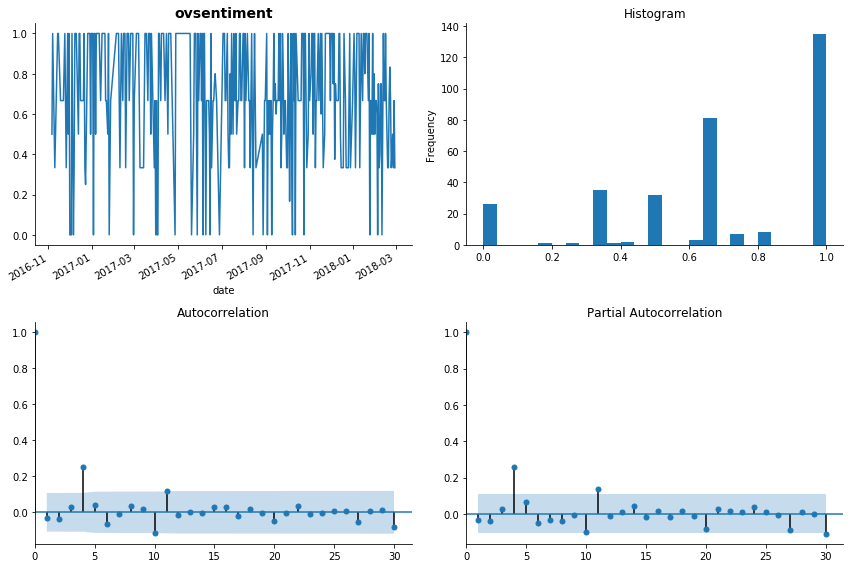

In [16]:
num_var1 = len(prod1.iloc[1, :])
for i in range(0, num_var1):
    tsplot(prod1.iloc[:, i].dropna(), title=prod1.columns[i], lags=30)
plt.show()

In [17]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [18]:
prod1_transformed = prod1.copy()
prod1_transformed['Sales'] = np.log(prod1_transformed['Sales'])
prod1_transformed['Sales'] = prod1_transformed['Sales'].diff(10)

In [19]:
prod1_transformed['rating'] = prod1_transformed['rating'].diff(1)
prod1_transformed['ovsentiment'] = prod1_transformed['ovsentiment'].diff(1)

In [20]:
prod1_transformed.dropna(inplace=True)

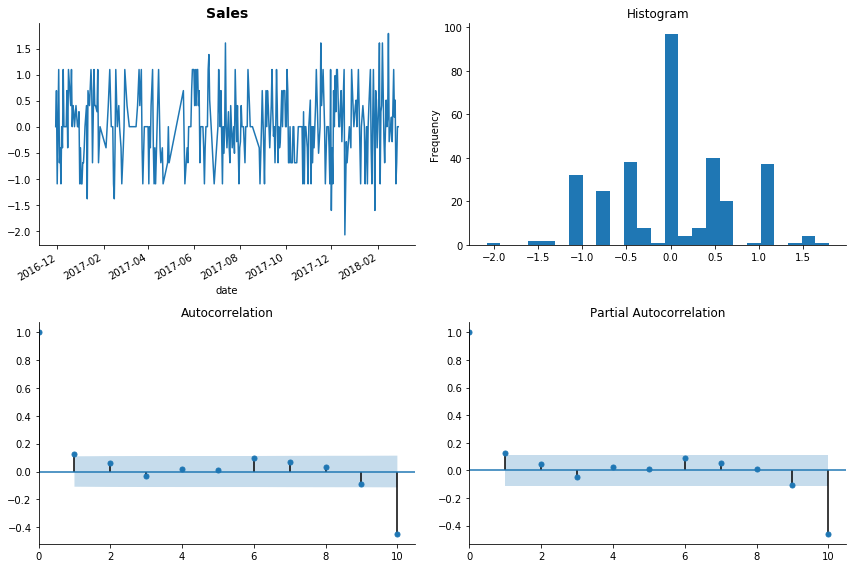

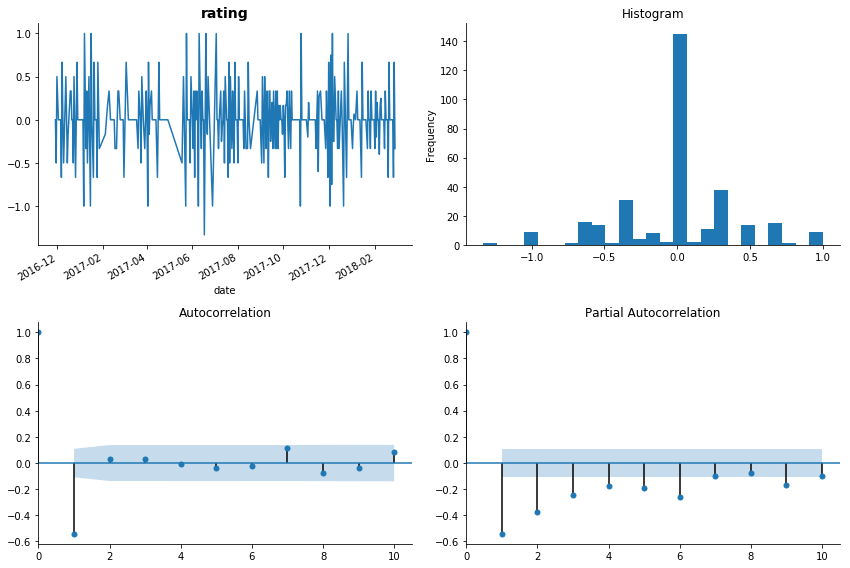

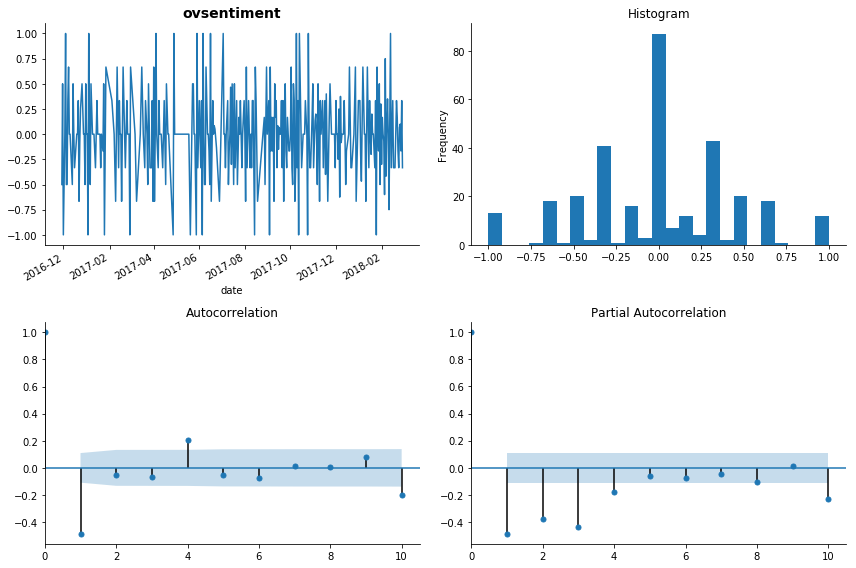

In [21]:
num_var1 = len(prod1_transformed.iloc[1, :])
for i in range(0, num_var1):
    tsplot(prod1_transformed.iloc[:, i].dropna(), title=prod1_transformed.columns[i], lags=10)
plt.show()

In [22]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [23]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['Sales'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-8.651998e+00,Test Statistic
1,2.247896e-12,p-value
2,9.000000e+00,#Lags Used
3,3.120000e+02,Number of Observations Used
4,-3.988083e+00,Critical value for 1%
5,-3.424656e+00,Critical value for 5%
6,-3.135378e+00,Critical value for 10%


In [24]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['rating'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-7.816325e+00,Test Statistic
1,1.899364e-10,p-value
2,1.600000e+01,#Lags Used
3,3.050000e+02,Number of Observations Used
4,-3.988763e+00,Critical value for 1%
5,-3.424983e+00,Critical value for 5%
6,-3.135570e+00,Critical value for 10%


In [25]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['ovsentiment'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-9.356789e+00,Test Statistic
1,5.758032e-14,p-value
2,9.000000e+00,#Lags Used
3,3.120000e+02,Number of Observations Used
4,-3.988083e+00,Critical value for 1%
5,-3.424656e+00,Critical value for 5%
6,-3.135378e+00,Critical value for 10%


In [26]:
# Train-Test Set Split
train1 = ceil(prod1_transformed.shape[0] * 0.8)
y_train1 = prod1_transformed[0:train1]
y_test1 = prod1_transformed[train1:]
y_train1.shape, y_test1.shape

((258, 3), (64, 3))

In [27]:
y_train1.dropna().shape

(258, 3)

In [28]:
BIC1 = detpq(y_train1, par=range(0,6))

In [29]:
BIC1.head()

,index,param,BIC
0,0,"(0, 1)",819.103314
1,6,"(1, 1)",855.608271
2,12,"(2, 1)",888.738958
3,1,"(0, 2)",888.893944
4,7,"(1, 2)",890.744830


In [30]:
model1 = sm.tsa.VARMAX(y_train1, order=(0, 1))
result1 = model1.fit(maxiter=1000, disp=False)

In [31]:
result1.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,258
Model:,VMA(1),Log Likelihood,-356.548
,+ intercept,AIC,749.097
Date:,"Tue, 04 Sep 2018",BIC,813.050
Time:,16:12:21,HQIC,774.813
Sample:,0,,
,- 258,,
Covariance Type:,opg,,
Ljung-Box (Q):,"126.33, 39.47, 44.00",Jarque-Bera (JB):,"1.53, 201.77, 29.39"
Prob(Q):,"0.00, 0.49, 0.31",Prob(JB):,"0.46, 0.00, 0.00"
Heteroskedasticity (H):,"0.94, 0.85, 0.66",Skew:,"0.02, -1.70, -0.83"


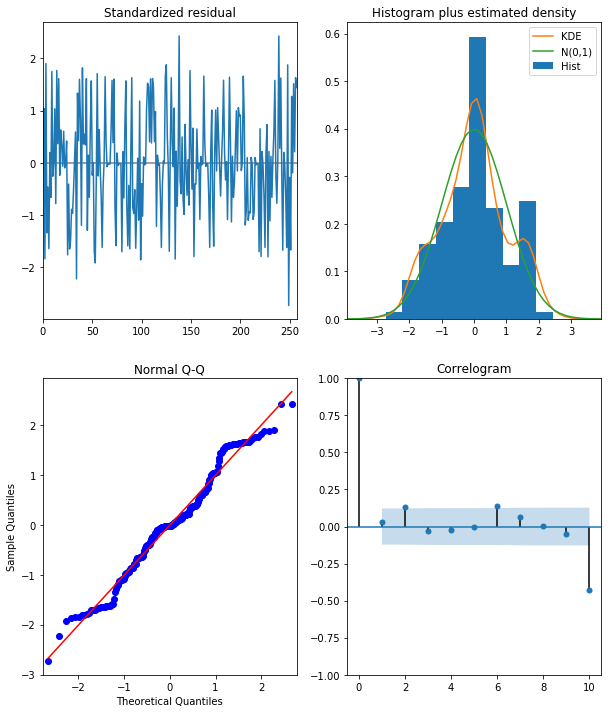

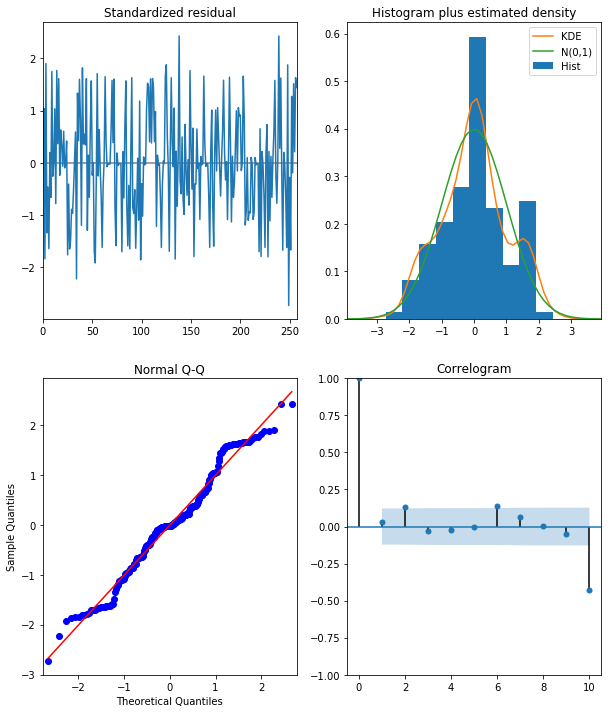

In [32]:
result1.plot_diagnostics(figsize=(10, 12))

In [33]:
plt.clf()
y_test1.shape

(64, 3)

<Figure size 432x288 with 0 Axes>

In [34]:
y_pred1 = result1.get_prediction(start=train1+1, end=prod1_transformed.shape[0])
y_forecasted1 = y_pred1.predicted_mean
y_forecasted1.shape

(64, 3)

In [35]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted1), y_true=np.exp(y_test1)))

0.7782022533067195

In [36]:
mean_absolute_error(y_pred=np.exp(y_forecasted1), y_true=np.exp(y_test1))

0.4200864440621337

## <font color=blue> 2. Mongodb ID: 5aa39533ae1f941be7165ecd </font>

In [35]:
prod2 = genData('5aa39533ae1f941be7165ecd', conn, c, impute=True, freq='daily', standardize=False)
prod2.head()

,Sales,rating,ovsentiment
date,,,
2016-07-29,8,5.0,0.5
2016-07-30,15,5.0,0.0
2016-07-31,11,3.0,0.0
2016-08-01,10,3.0,0.0
2016-08-02,6,3.0,0.0


In [36]:
#prod2 = prod2[prod2['Sales'] != 0]
prod2.shape

(579, 3)

In [37]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['Sales'], '5aa39533ae1f941be7165ecd')
prod2Test.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-22.354811,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,578.000000,Number of Observations Used
4,-3.974519,Critical value for 1%
5,-3.418113,Critical value for 5%
6,-3.131535,Critical value for 10%


In [38]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['rating'], '5aa39533ae1f941be7165ecd')
prod2Test.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-3.558126,Test Statistic
1,0.033571,p-value
2,13.000000,#Lags Used
3,565.000000,Number of Observations Used
4,-3.974883,Critical value for 1%
5,-3.418289,Critical value for 5%
6,-3.131639,Critical value for 10%


In [39]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['ovsentiment'], '5aa39533ae1f941be7165ecd')
prod2Test.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-7.626013e+00,Test Statistic
1,5.223725e-10,p-value
2,5.000000e+00,#Lags Used
3,5.730000e+02,Number of Observations Used
4,-3.974657e+00,Critical value for 1%
5,-3.418180e+00,Critical value for 5%
6,-3.131574e+00,Critical value for 10%


<Figure size 432x288 with 0 Axes>

<Figure size 720x864 with 0 Axes>

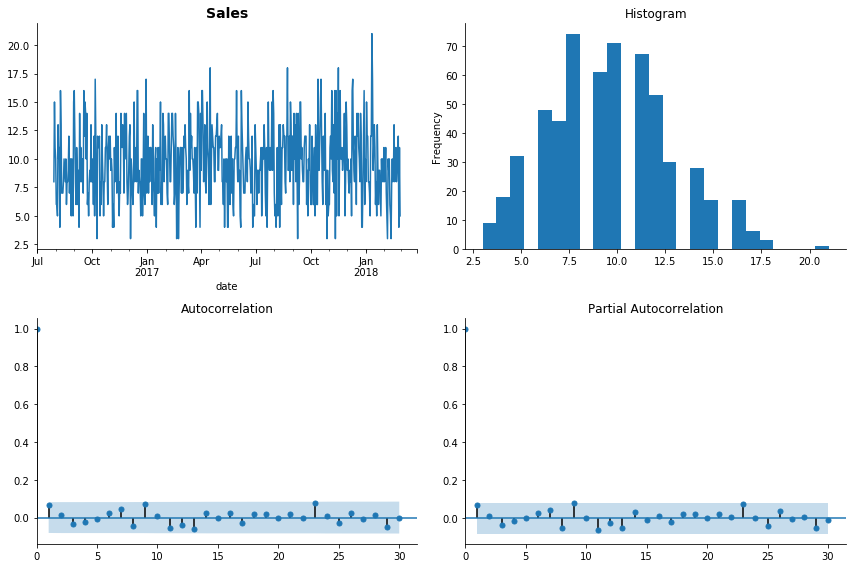

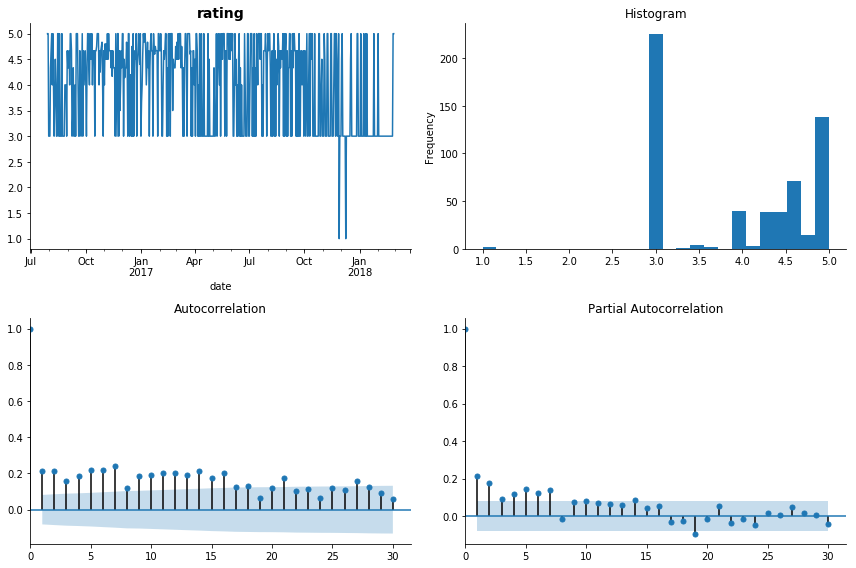

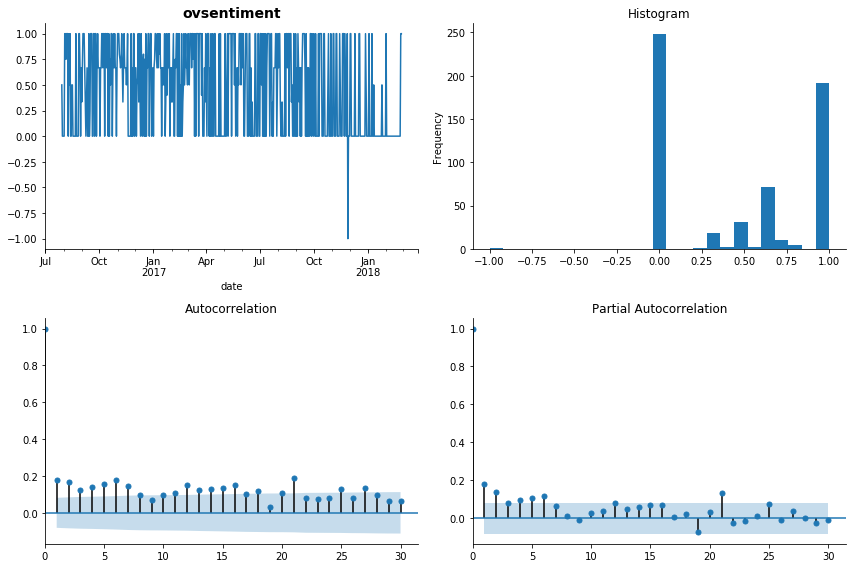

In [40]:
num_var2 = len(prod2.iloc[1, :])
for i in range(0, num_var2):
    tsplot(prod2.iloc[:, i].dropna(), title=prod2.columns[i], lags=30)
plt.show()

In [41]:
plt.clf()

In [42]:
prod2_transformed = prod2.copy()
prod2_transformed['Sales'] = np.log(prod2_transformed['Sales'])
prod2_transformed['Sales'] = prod2_transformed['Sales'].diff(10)
prod2_transformed['rating'] = prod2_transformed['rating'].diff(1)
prod2_transformed['ovsentiment'] = prod2_transformed['ovsentiment'].diff(1)
prod2_transformed.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

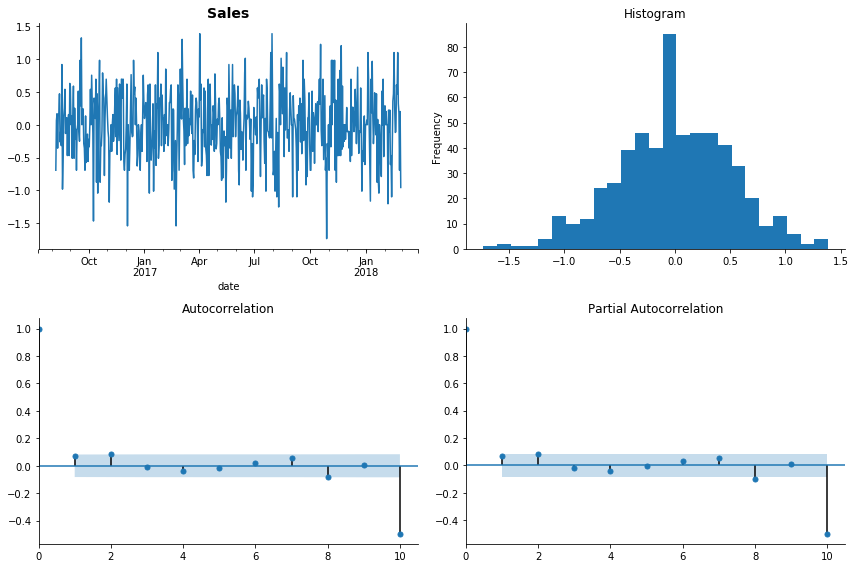

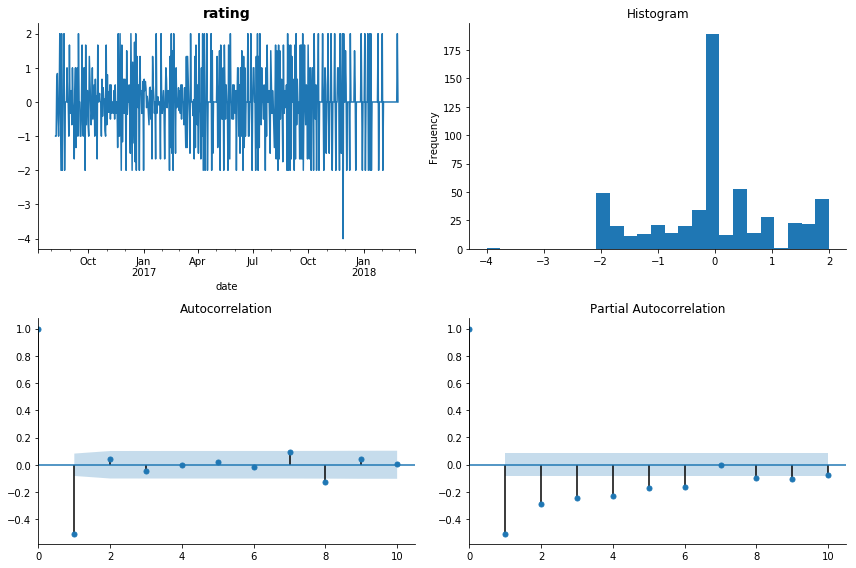

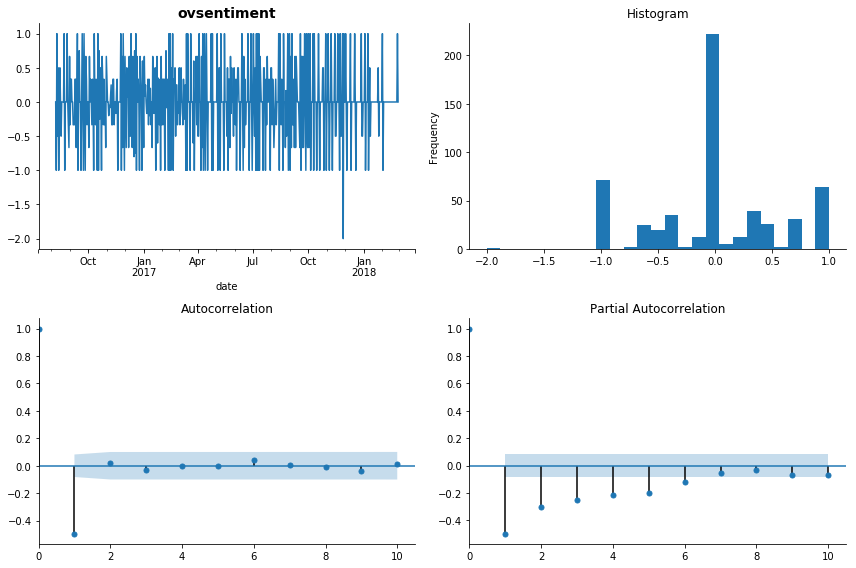

In [43]:
num_var2 = len(prod2_transformed.iloc[1, :])
for i in range(0, num_var2):
    tsplot(prod2_transformed.iloc[:, i].dropna(), title=prod2_transformed.columns[i], lags=10)
plt.show()

In [44]:
plt.clf()

In [45]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['Sales'].dropna(), '5aa39533ae1f941be7165ecd')
prod2_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-9.190621e+00,Test Statistic
1,1.351568e-13,p-value
2,1.900000e+01,#Lags Used
3,5.490000e+02,Number of Observations Used
4,-3.975355e+00,Critical value for 1%
5,-3.418517e+00,Critical value for 5%
6,-3.131773e+00,Critical value for 10%


In [46]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['rating'].dropna(), '5aa39533ae1f941be7165ecd')
prod2_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-1.072123e+01,Test Statistic
1,7.705622e-17,p-value
2,1.400000e+01,#Lags Used
3,5.540000e+02,Number of Observations Used
4,-3.975205e+00,Critical value for 1%
5,-3.418445e+00,Critical value for 5%
6,-3.131730e+00,Critical value for 10%


In [47]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['ovsentiment'].dropna(), '5aa39533ae1f941be7165ecd')
prod2_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-8.887883e+00,Test Statistic
1,6.514117e-13,p-value
2,1.900000e+01,#Lags Used
3,5.490000e+02,Number of Observations Used
4,-3.975355e+00,Critical value for 1%
5,-3.418517e+00,Critical value for 5%
6,-3.131773e+00,Critical value for 10%


In [48]:
# Train-Test Set Split
train2 = ceil(prod2_transformed.shape[0] * 0.8)
y_train2 = prod2_transformed[0:train2]
y_test2 = prod2_transformed[train2:]
y_train2.shape, y_test2.shape

((456, 3), (113, 3))

In [49]:
y_train2.dropna().shape

(456, 3)

In [50]:
BIC2 = detpq(y_train2, par=range(0,6))
BIC2.head()

,index,param,BIC
0,0,"(0, 1)",1996.535259
1,6,"(1, 1)",2047.849440
2,1,"(0, 2)",2087.587723
3,7,"(1, 2)",2093.312420
4,12,"(2, 1)",2100.189811


In [51]:
model2 = sm.tsa.VARMAX(y_train2, order=(0, 1))
result2 = model2.fit(maxiter=1000, disp=False)

In [53]:
result2.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,456
Model:,VMA(1),Log Likelihood,-939.704
,+ intercept,AIC,1915.409
Date:,"Tue, 10 Jul 2018",BIC,1989.613
Time:,17:01:56,HQIC,1944.639
Sample:,08-08-2016,,
,- 11-06-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"177.82, 68.69, 27.65",Jarque-Bera (JB):,"3.47, 35.73, 66.52"
Prob(Q):,"0.00, 0.00, 0.93",Prob(JB):,"0.18, 0.00, 0.00"
Heteroskedasticity (H):,"1.14, 1.44, 0.89",Skew:,"-0.19, -0.38, -0.49"


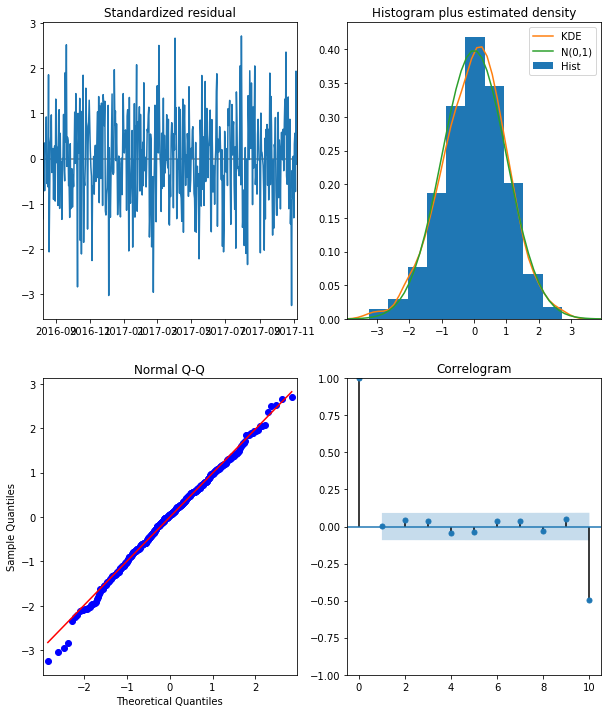

In [54]:
result2.plot_diagnostics(figsize=(10, 12))

In [55]:
plt.clf()
y_test2.shape

(113, 3)

In [56]:
y_pred2 = result2.get_prediction(start=train2+1, end=prod2_transformed.shape[0])
y_forecasted2 = y_pred2.predicted_mean
y_forecasted2.shape

(113, 3)

In [57]:
np.sqrt(mean_squared_error(y_pred=y_forecasted2, y_true=y_test2))

0.7555954274944542

In [58]:
mean_absolute_error(y_pred=y_forecasted2, y_true=y_test2)

0.4168082910826971

## <font color=blue> 3. Mongodb ID: 5a93e8768cbad97881597597 </font>

In [59]:
prod3 = genData('5a93e8768cbad97881597597', conn, c, impute=True, freq='daily', standardize=False)
prod3.head()

,Sales,rating,ovsentiment
date,,,
2015-02-04,20,5.0,0.666667
2015-02-05,45,3.0,0.000000
2015-02-06,30,3.0,0.000000
2015-02-07,30,3.0,0.000000
2015-02-08,15,3.0,0.000000


In [60]:
#prod3 = prod3[prod3['Sales'] != 0]
prod3.shape

(1118, 3)

In [61]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['Sales'], '5a93e8768cbad97881597597')
prod3Test.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-32.242213,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,1117.000000,Number of Observations Used
4,-3.966898,Critical value for 1%
5,-3.414428,Critical value for 5%
6,-3.129368,Critical value for 10%


In [62]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['rating'], '5a93e8768cbad97881597597')
prod3Test.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-4.100750,Test Statistic
1,0.006291,p-value
2,16.000000,#Lags Used
3,1101.000000,Number of Observations Used
4,-3.967016,Critical value for 1%
5,-3.414485,Critical value for 5%
6,-3.129402,Critical value for 10%


In [63]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['ovsentiment'], '5a93e8768cbad97881597597')
prod3Test.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-4.978540,Test Statistic
1,0.000225,p-value
2,15.000000,#Lags Used
3,1102.000000,Number of Observations Used
4,-3.967009,Critical value for 1%
5,-3.414482,Critical value for 5%
6,-3.129400,Critical value for 10%


<Figure size 432x288 with 0 Axes>

<Figure size 720x864 with 0 Axes>

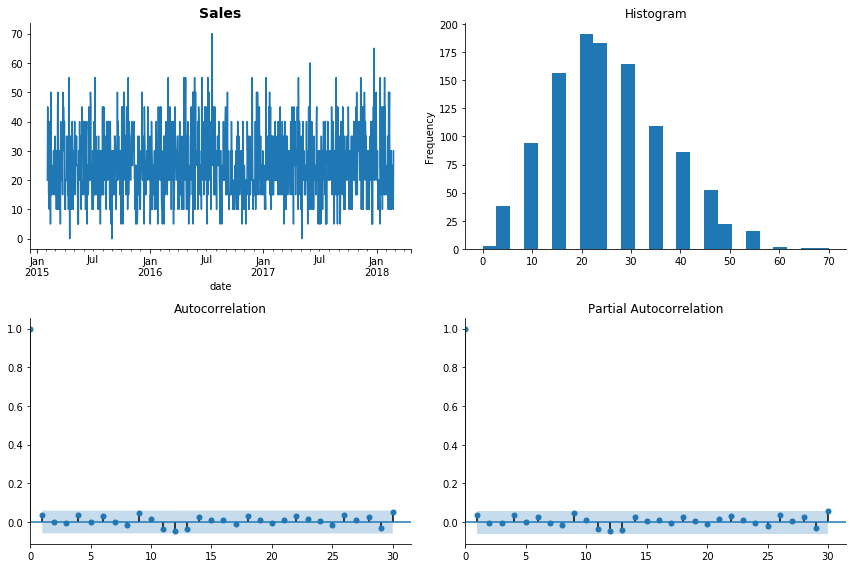

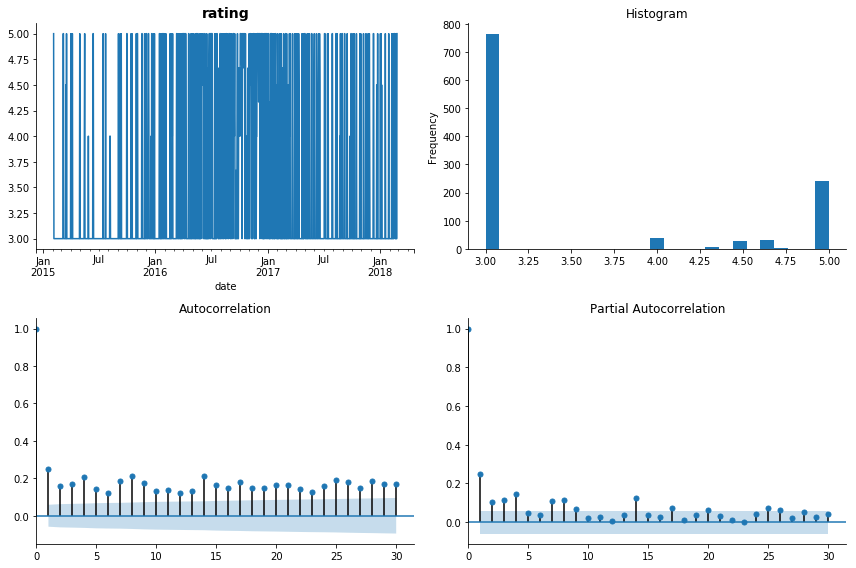

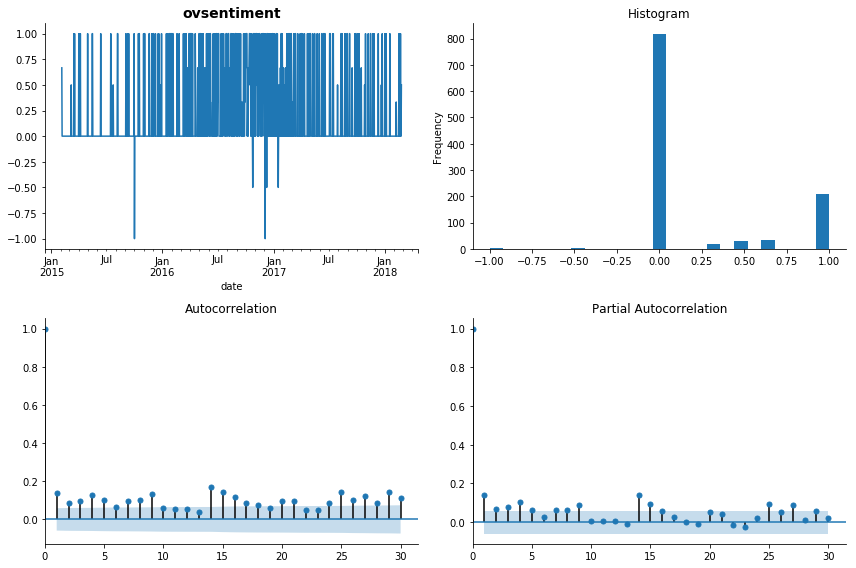

In [64]:
num_var3 = len(prod3.iloc[1, :])
for i in range(0, num_var3):
    tsplot(prod3.iloc[:, i].dropna(), title=prod3.columns[i], lags=30)
plt.show()

In [65]:
plt.clf()

In [100]:
prod3_transformed = prod3.copy()
prod3_transformed['Sales'] = np.log(prod3_transformed['Sales'])
prod3_transformed['Sales'] = prod3_transformed['Sales'].replace(-np.inf, 0)
prod3_transformed['Sales'] = prod3_transformed['Sales'].diff(10)
prod3_transformed['rating'] = np.log(prod3_transformed['rating']).diff(1)
prod3_transformed['rating'] = prod3_transformed['rating'].replace(-np.inf,0)
prod3_transformed['rating'] = prod3_transformed['rating'].replace(np.inf,0)
prod3_transformed['ovsentiment'] = np.log(prod3_transformed['ovsentiment']).diff(1)
prod3_transformed['ovsentiment'] = prod3_transformed['ovsentiment'].replace(-np.inf,0)
prod3_transformed['ovsentiment'] = prod3_transformed['ovsentiment'].replace(np.inf,0)
prod3_transformed.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

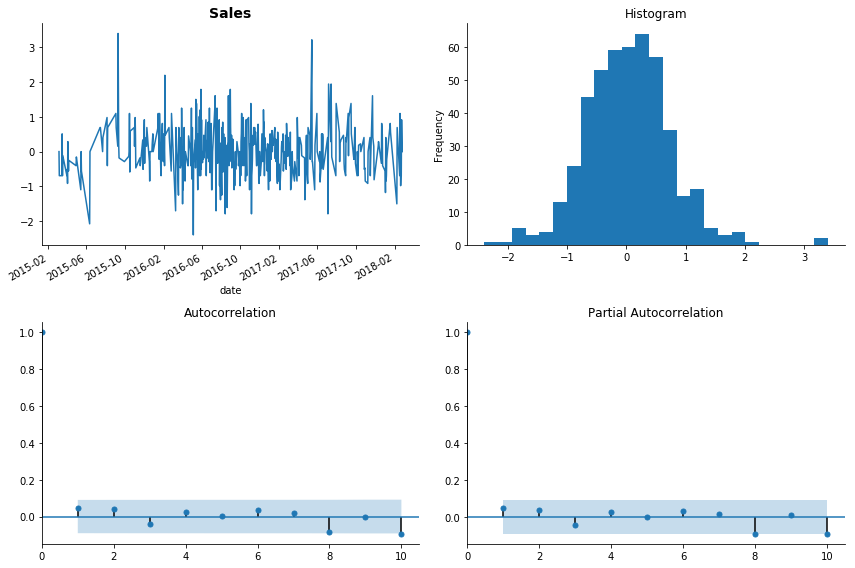

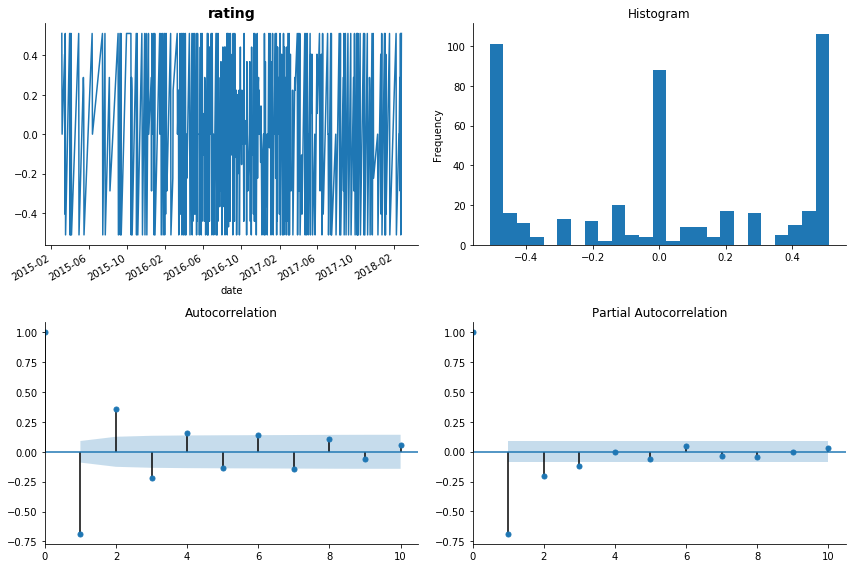

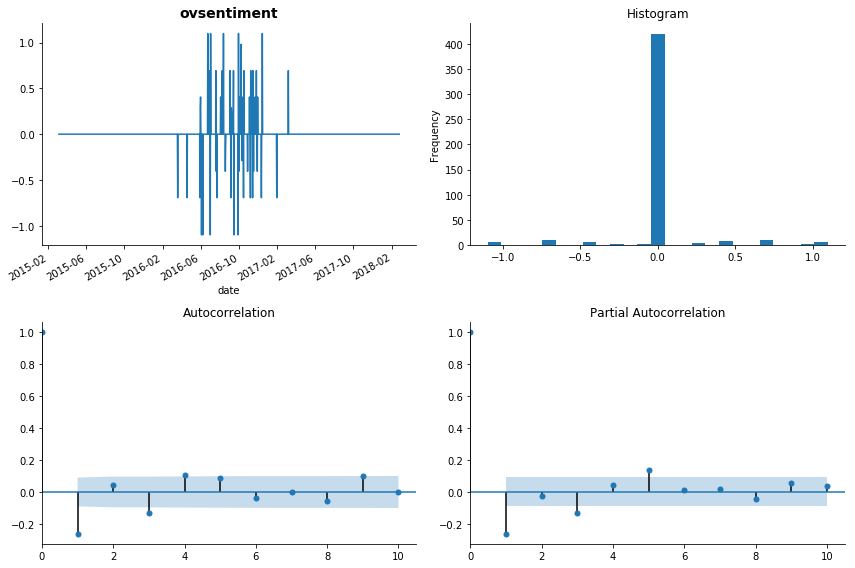

In [103]:
num_var3 = len(prod3_transformed.iloc[1, :])
for i in range(0, num_var3):
    tsplot(prod3_transformed.iloc[:, i].dropna(), title=prod3_transformed.columns[i], lags=10)
plt.show()

In [104]:
plt.clf()

In [105]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['Sales'].dropna(), '5a93e8768cbad97881597597')
prod3_transformedTest.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-20.623019,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,470.000000,Number of Observations Used
4,-3.978162,Critical value for 1%
5,-3.419873,Critical value for 5%
6,-3.132569,Critical value for 10%


In [106]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['rating'].dropna(), '5a93e8768cbad97881597597')
prod3_transformedTest.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-18.654883,Test Statistic
1,0.000000,p-value
2,2.000000,#Lags Used
3,468.000000,Number of Observations Used
4,-3.978245,Critical value for 1%
5,-3.419913,Critical value for 5%
6,-3.132593,Critical value for 10%


In [107]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['ovsentiment'].dropna(), '5a93e8768cbad97881597597')
prod3_transformedTest.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-5.449904,Test Statistic
1,0.000029,p-value
2,17.000000,#Lags Used
3,453.000000,Number of Observations Used
4,-3.978895,Critical value for 1%
5,-3.420226,Critical value for 5%
6,-3.132777,Critical value for 10%


In [108]:
# Train-Test Set Split
train3 = ceil(prod3_transformed.shape[0] * 0.8)
y_train3 = prod3_transformed[0:train3]
y_test3 = prod3_transformed[train3:]
y_train3.shape, y_test3.shape

((377, 3), (94, 3))

In [109]:
y_train3.dropna().shape

(377, 3)

In [110]:
BIC3 = detpq(y_train3, par=range(0,6))
BIC3.head()

,index,param,BIC
0,5,"(1, 0)",1022.681163
1,0,"(0, 1)",1037.904154
2,6,"(1, 1)",1047.793070
3,11,"(2, 0)",1048.547553
4,1,"(0, 2)",1054.037928


In [111]:
model3 = sm.tsa.VARMAX(y_train3, order=(1, 0))
result3 = model3.fit(maxiter=1000, disp=False)

In [112]:
result3.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,377
Model:,VAR(1),Log Likelihood,-457.950
,+ intercept,AIC,951.901
Date:,"Tue, 10 Jul 2018",BIC,1022.681
Time:,17:22:54,HQIC,979.995
Sample:,0,,
,- 377,,
Covariance Type:,opg,,
Ljung-Box (Q):,"39.16, 69.25, 71.25",Jarque-Bera (JB):,"46.73, 10.60, 1008.54"
Prob(Q):,"0.51, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.55, 0.88, 5.28",Skew:,"0.22, -0.30, -0.10"


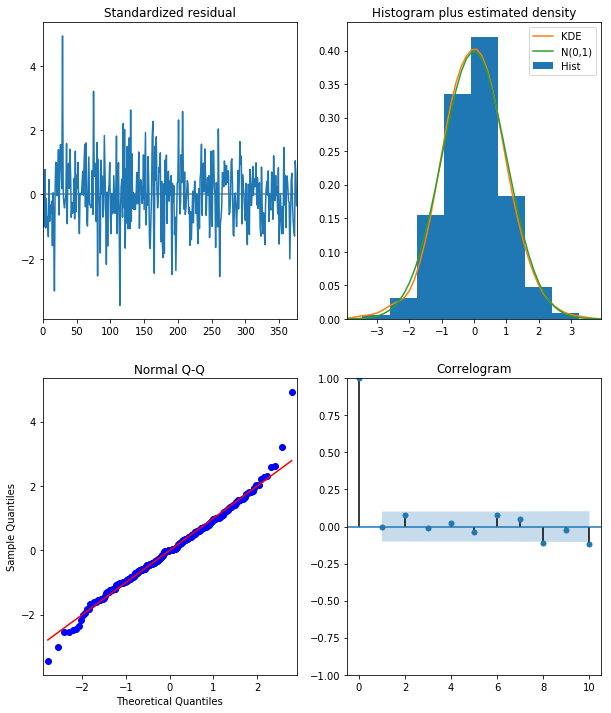

In [113]:
result3.plot_diagnostics(figsize=(10, 12))

In [114]:
plt.clf()
y_test3.shape

(94, 3)

In [115]:
y_pred3 = result3.get_prediction(start=train3+1, end=prod3_transformed.shape[0])
y_forecasted3 = y_pred3.predicted_mean
y_forecasted3.shape

(94, 3)

In [116]:
np.sqrt(mean_squared_error(y_pred=y_forecasted3, y_true=y_test3))

0.519214214644676

In [117]:
mean_absolute_error(y_pred=y_forecasted3, y_true=y_test3)

0.3345192996410011

## <font color=blue> 4. Mongodb ID: 5a95d7ae35d6d33d3fea56ff </font>

In [118]:
prod4 = genData('5a95d7ae35d6d33d3fea56ff', conn, c, impute=True, freq='daily', standardize=False)
prod4.head()

,Sales,rating,ovsentiment
date,,,
2016-04-06,5,5.0,0.0
2016-04-07,10,3.5,0.0
2016-04-08,7,3.0,0.0
2016-04-09,6,3.0,0.0
2016-04-10,3,3.0,0.0


In [119]:
#prod4 = prod4[prod4['Sales'] != 0]
prod4.shape

(692, 3)

In [120]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['Sales'], '5a95d7ae35d6d33d3fea56ff')
prod4Test.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-24.204783,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,691.000000,Number of Observations Used
4,-3.971931,Critical value for 1%
5,-3.416863,Critical value for 5%
6,-3.130800,Critical value for 10%


In [121]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['rating'], '5a95d7ae35d6d33d3fea56ff')
prod4Test.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-6.986116e+00,Test Statistic
1,1.518956e-08,p-value
2,6.000000e+00,#Lags Used
3,6.850000e+02,Number of Observations Used
4,-3.972047e+00,Critical value for 1%
5,-3.416919e+00,Critical value for 5%
6,-3.130833e+00,Critical value for 10%


In [122]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['ovsentiment'], '5a95d7ae35d6d33d3fea56ff')
prod4Test.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-7.236126e+00,Test Statistic
1,4.104535e-09,p-value
2,6.000000e+00,#Lags Used
3,6.850000e+02,Number of Observations Used
4,-3.972047e+00,Critical value for 1%
5,-3.416919e+00,Critical value for 5%
6,-3.130833e+00,Critical value for 10%


<Figure size 432x288 with 0 Axes>

<Figure size 720x864 with 0 Axes>

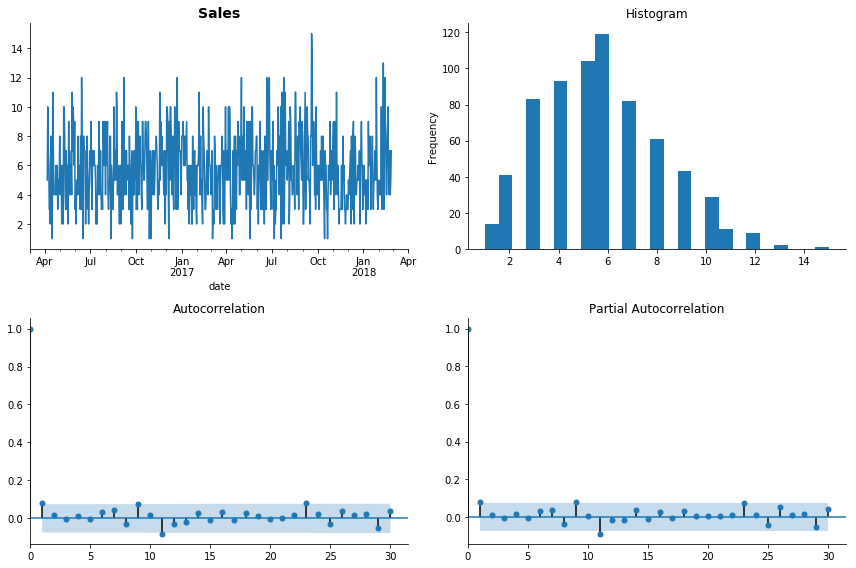

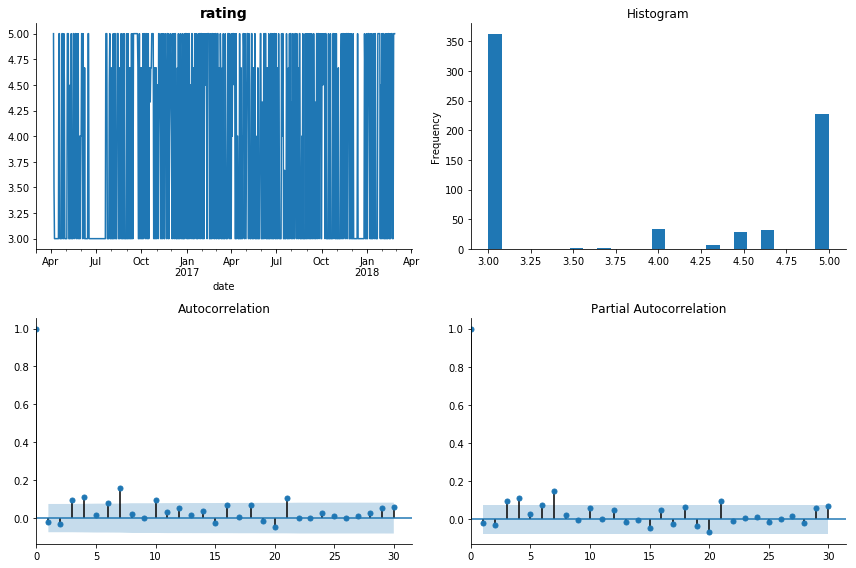

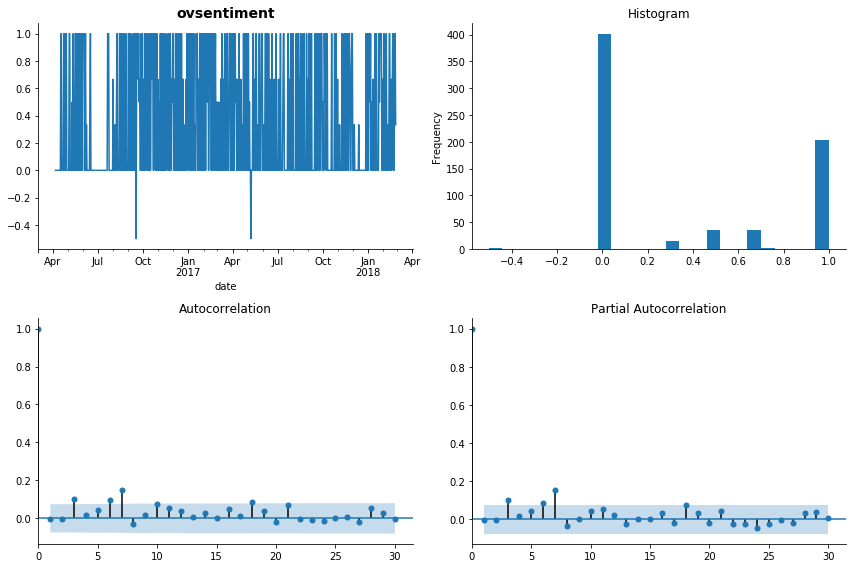

In [123]:
num_var4 = len(prod4.iloc[1, :])
for i in range(0, num_var4):
    tsplot(prod4.iloc[:, i].dropna(), title=prod4.columns[i], lags=30)
plt.show()

In [124]:
plt.clf()

In [125]:
prod4_transformed = prod4.copy()
prod4_transformed['Sales'] = np.log(prod4_transformed['Sales'])
prod4_transformed['Sales'] = prod4_transformed['Sales'].diff(10)
prod4_transformed['rating'] = prod4_transformed['rating'].diff(1)
prod4_transformed['ovsentiment'] = prod4_transformed['ovsentiment'].diff(1)
prod4_transformed.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

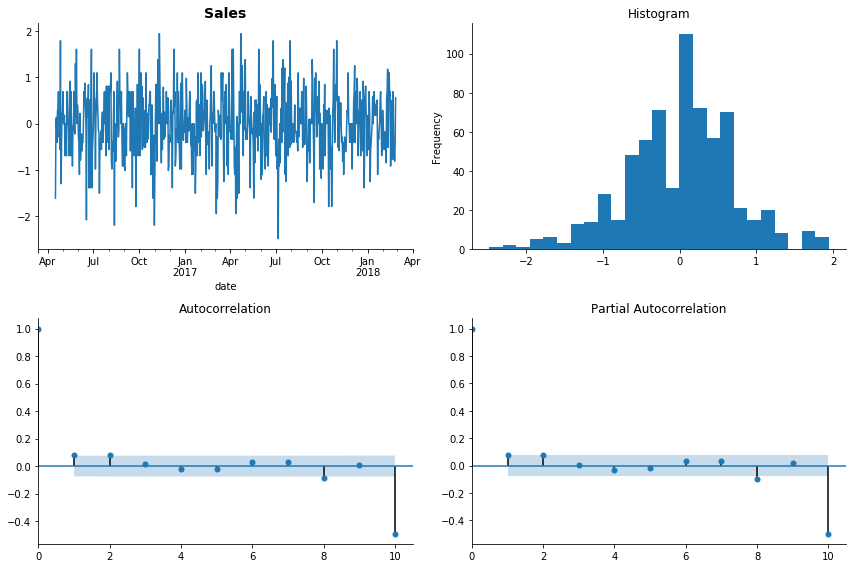

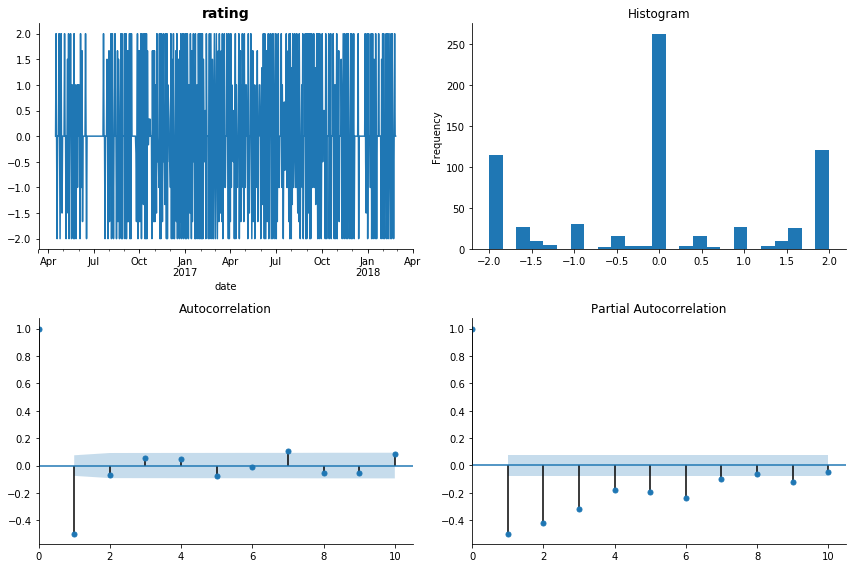

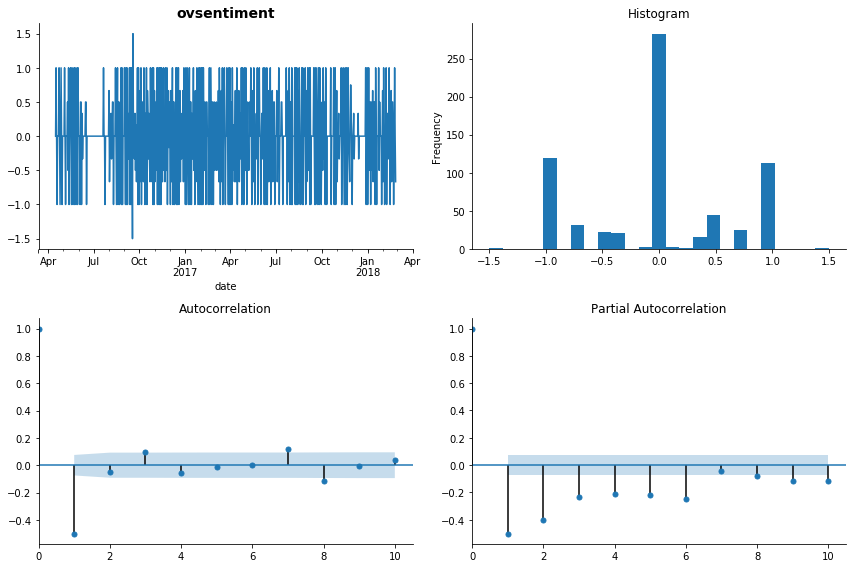

In [126]:
num_var4 = len(prod4_transformed.iloc[1, :])
for i in range(0, num_var4):
    tsplot(prod4_transformed.iloc[:, i].dropna(), title=prod4_transformed.columns[i], lags=10)
plt.show()

In [127]:
plt.clf()

In [128]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['Sales'].dropna(), '5a95d7ae35d6d33d3fea56ff')
prod4_transformedTest.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-1.044140e+01,Test Statistic
1,2.795964e-16,p-value
2,1.900000e+01,#Lags Used
3,6.620000e+02,Number of Observations Used
4,-3.972511e+00,Critical value for 1%
5,-3.417143e+00,Critical value for 5%
6,-3.130965e+00,Critical value for 10%


In [129]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['rating'].dropna(), '5a95d7ae35d6d33d3fea56ff')
prod4_transformedTest.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-8.752044e+00,Test Statistic
1,1.327718e-12,p-value
2,1.900000e+01,#Lags Used
3,6.620000e+02,Number of Observations Used
4,-3.972511e+00,Critical value for 1%
5,-3.417143e+00,Critical value for 5%
6,-3.130965e+00,Critical value for 10%


In [130]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['ovsentiment'].dropna(), '5a95d7ae35d6d33d3fea56ff')
prod4_transformedTest.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-1.014270e+01,Test Statistic
1,1.154996e-15,p-value
2,1.700000e+01,#Lags Used
3,6.640000e+02,Number of Observations Used
4,-3.972469e+00,Critical value for 1%
5,-3.417123e+00,Critical value for 5%
6,-3.130953e+00,Critical value for 10%


In [131]:
# Train-Test Set Split
train4 = ceil(prod4_transformed.shape[0] * 0.8)
y_train4 = prod4_transformed[0:train4]
y_test4 = prod4_transformed[train4:]
y_train4.shape, y_test4.shape

((546, 3), (136, 3))

In [132]:
y_train4.dropna().shape

(546, 3)

In [133]:
BIC4 = detpq(y_train4, par=range(0,6))
BIC4.head()

,index,param,BIC
0,0,"(0, 1)",2862.375610
1,6,"(1, 1)",2915.596209
2,12,"(2, 1)",2957.980322
3,7,"(1, 2)",2962.945512
4,18,"(3, 1)",3009.440524


In [134]:
model4 = sm.tsa.VARMAX(y_train4, order=(0, 1))
result4 = model4.fit(maxiter=1000, disp=False)

result4.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,546
Model:,VMA(1),Log Likelihood,-1373.574
,+ intercept,AIC,2783.148
Date:,"Tue, 10 Jul 2018",BIC,2860.595
Time:,18:14:02,HQIC,2813.422
Sample:,04-16-2016,,
,- 10-13-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"191.60, 54.06, 40.29",Jarque-Bera (JB):,"8.04, 67.27, 470.09"
Prob(Q):,"0.00, 0.07, 0.46",Prob(JB):,"0.02, 0.00, 0.00"
Heteroskedasticity (H):,"1.00, 1.02, 1.41",Skew:,"-0.21, 0.17, -1.07"


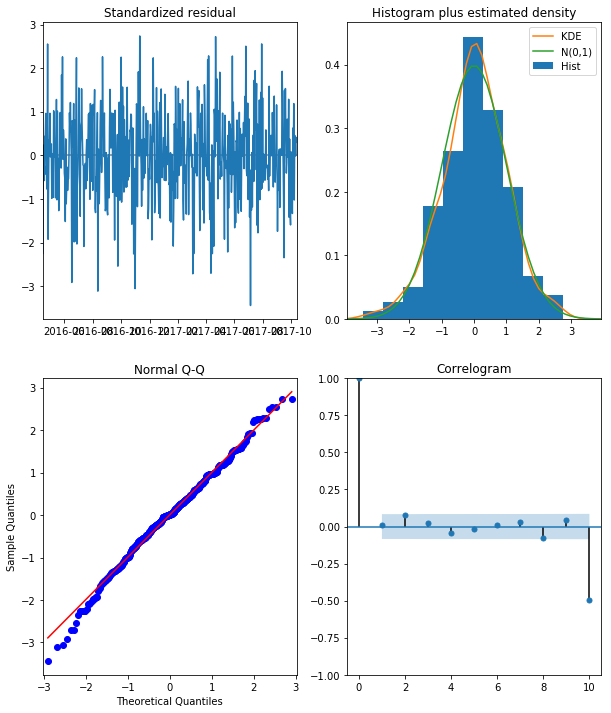

In [135]:
result4.plot_diagnostics(figsize=(10, 12))

In [136]:
plt.clf()
y_test4.shape

(136, 3)

In [137]:
y_pred4 = result4.get_prediction(start=train4+1, end=prod4_transformed.shape[0])
y_forecasted4 = y_pred4.predicted_mean
y_forecasted4.shape

(136, 3)

In [138]:
np.sqrt(mean_squared_error(y_pred=y_forecasted4, y_true=y_test4))

0.9082974880044298

In [139]:
mean_absolute_error(y_pred=y_forecasted4, y_true=y_test4)

0.600471458107784

## <font color=blue> 5. Mongodb ID: 5aa2c35e35d6d34b0032a796 </font>

In [185]:
prod5 = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=True, freq='daily', standardize=False)
prod5.head()

,Sales,rating,ovsentiment
date,,,
2016-12-28,0,5.0,1.0
2016-12-29,0,5.0,1.0
2016-12-30,0,3.0,0.0
2016-12-31,0,3.0,0.0
2017-01-01,0,3.0,0.0


In [186]:
#prod5 = prod5[prod5['Sales'] != 0]

prod5.shape

(427, 3)

In [187]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['Sales'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-20.916162,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,426.000000,Number of Observations Used
4,-3.980180,Critical value for 1%
5,-3.420846,Critical value for 5%
6,-3.133141,Critical value for 10%


In [188]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['rating'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-7.225179e+00,Test Statistic
1,4.347711e-09,p-value
2,4.000000e+00,#Lags Used
3,4.220000e+02,Number of Observations Used
4,-3.980384e+00,Critical value for 1%
5,-3.420945e+00,Critical value for 5%
6,-3.133199e+00,Critical value for 10%


In [189]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['ovsentiment'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-9.076695e+00,Test Statistic
1,2.436469e-13,p-value
2,3.000000e+00,#Lags Used
3,4.230000e+02,Number of Observations Used
4,-3.980333e+00,Critical value for 1%
5,-3.420920e+00,Critical value for 5%
6,-3.133185e+00,Critical value for 10%


<Figure size 432x288 with 0 Axes>

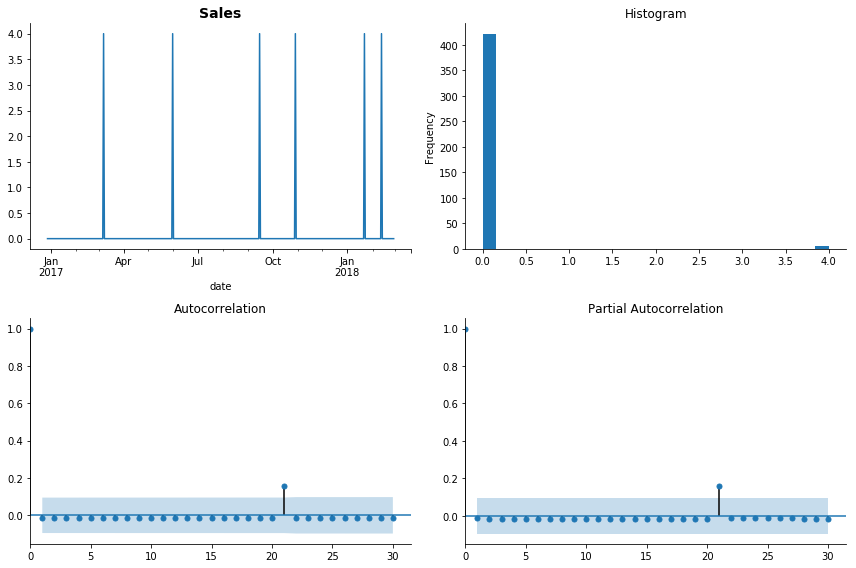

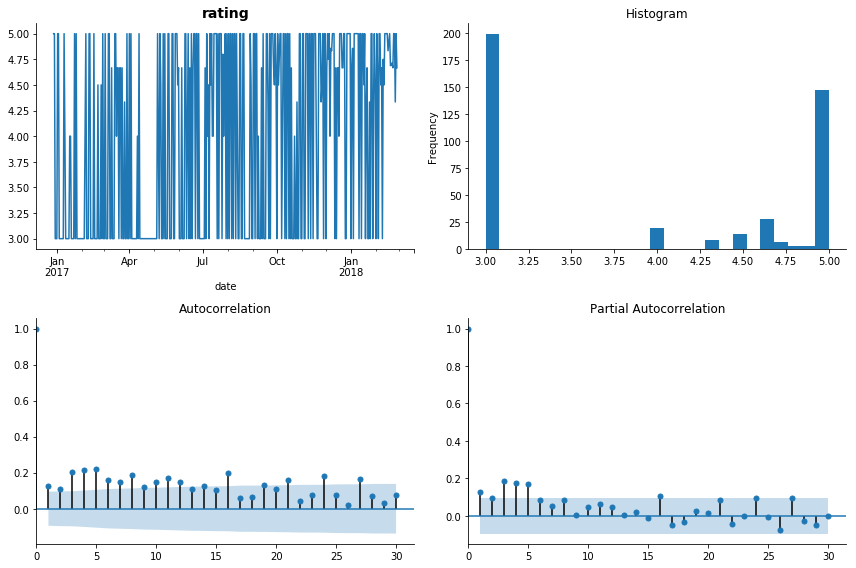

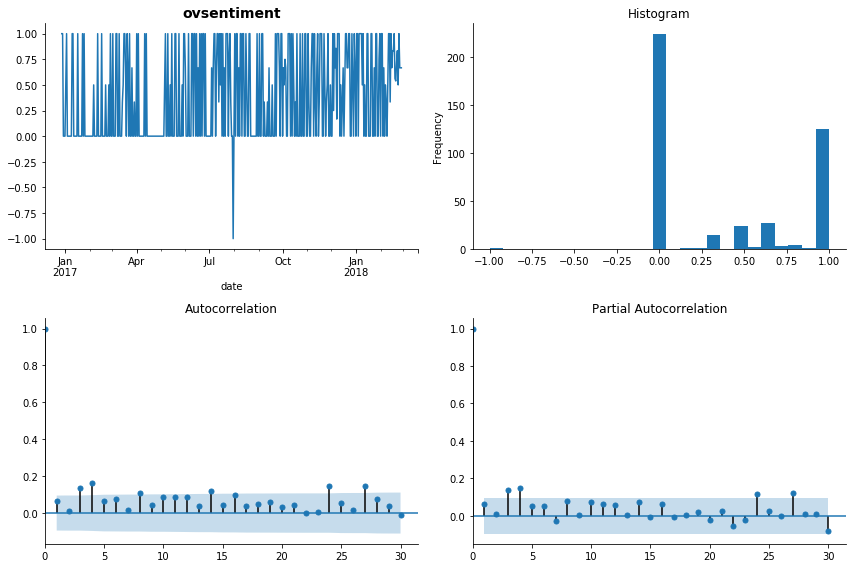

In [192]:
num_var5 = len(prod5.iloc[1, :])
for i in range(0, num_var5):
    tsplot(prod5.iloc[:, i].dropna(), title=prod5.columns[i], lags=30)
plt.show()

In [193]:
plt.clf()

In [194]:
prod5_transformed = prod5.copy()
prod5_transformed['Sales'] = np.log(prod5_transformed['Sales'])
prod5_transformed['Sales'] = prod5_transformed.replace(-np.inf, 0)
prod5_transformed['Sales'] = prod5_transformed['Sales'].diff(10)
prod5_transformed['rating'] = prod5_transformed['rating'].diff(1)
prod5_transformed['ovsentiment'] = prod5_transformed['ovsentiment'].diff(1)
prod5_transformed.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

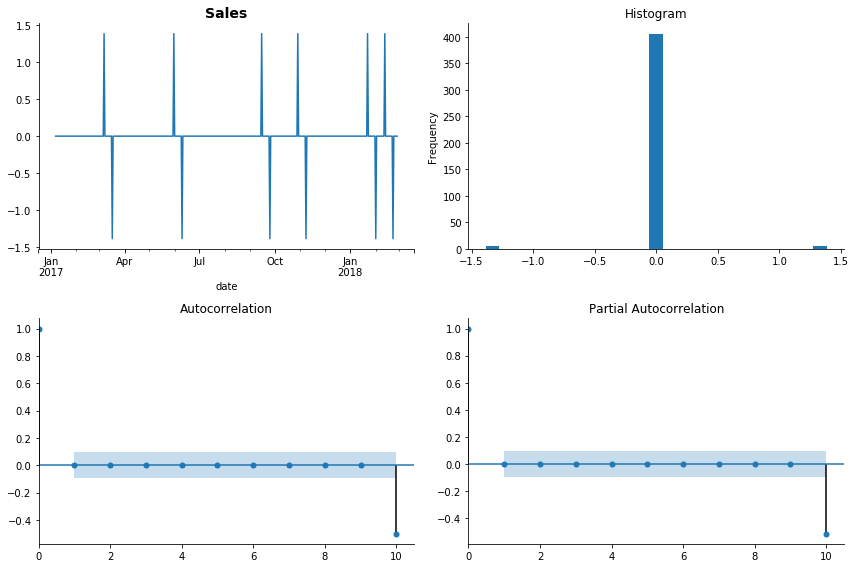

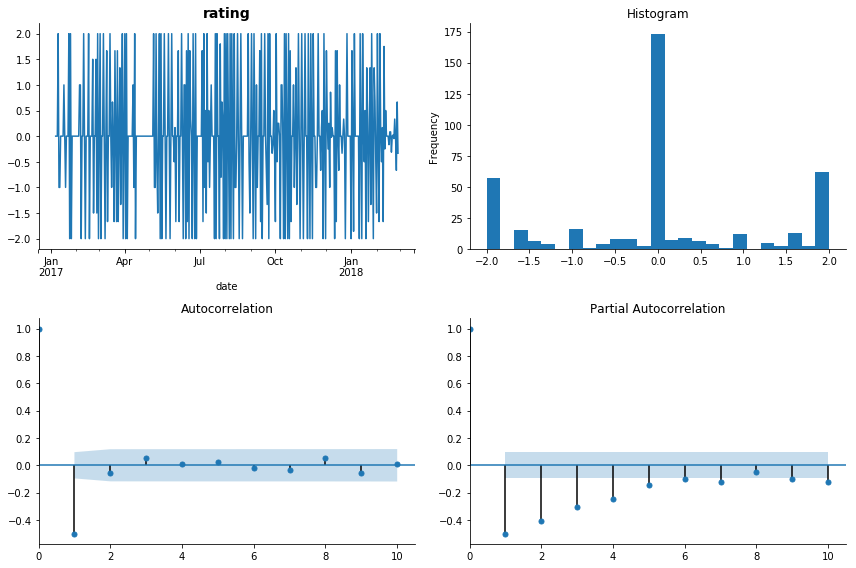

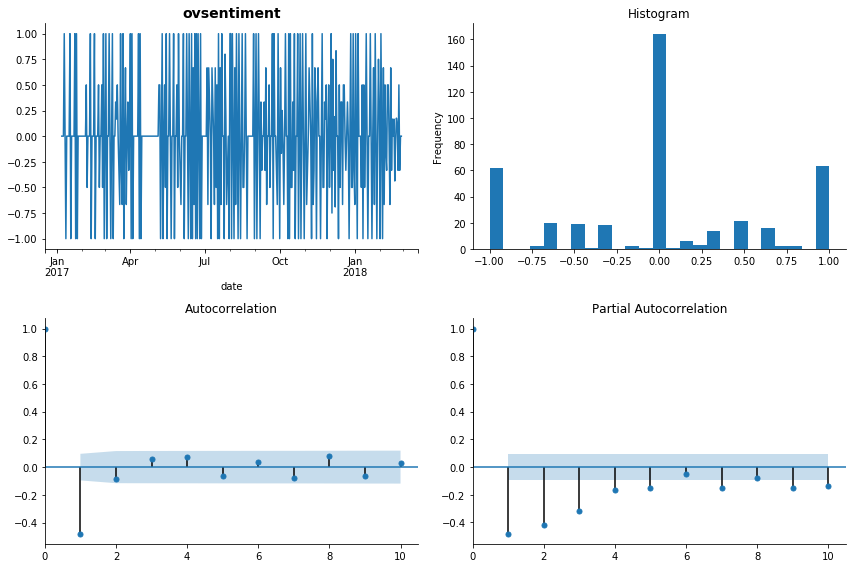

In [195]:
num_var5 = len(prod5_transformed.iloc[1, :])
for i in range(0, num_var5):
    tsplot(prod5_transformed.iloc[:, i].dropna(), title=prod5_transformed.columns[i], lags=10)
plt.show()

In [196]:
plt.clf()

In [197]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['Sales'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-1.091281e+01,Test Statistic
1,3.266673e-17,p-value
2,1.000000e+01,#Lags Used
3,4.060000e+02,Number of Observations Used
4,-3.981243e+00,Critical value for 1%
5,-3.421359e+00,Critical value for 5%
6,-3.133443e+00,Critical value for 10%


In [198]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['rating'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-1.011047e+01,Test Statistic
1,1.349339e-15,p-value
2,1.000000e+01,#Lags Used
3,4.060000e+02,Number of Observations Used
4,-3.981243e+00,Critical value for 1%
5,-3.421359e+00,Critical value for 5%
6,-3.133443e+00,Critical value for 10%


In [199]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['ovsentiment'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-1.084468e+01,Test Statistic
1,4.422014e-17,p-value
2,1.000000e+01,#Lags Used
3,4.060000e+02,Number of Observations Used
4,-3.981243e+00,Critical value for 1%
5,-3.421359e+00,Critical value for 5%
6,-3.133443e+00,Critical value for 10%


In [200]:
# Train-Test Set Split
train5 = ceil(prod5_transformed.shape[0] * 0.8)
y_train5 = prod5_transformed[0:train5]
y_test5 = prod5_transformed[train5:]
y_train5.shape, y_test5.shape

((334, 3), (83, 3))

In [201]:
#y_train5.dropna(inplace=True)
y_train5.shape

(334, 3)

In [202]:
BIC5 = detpq(y_train5, par=range(0,6))
BIC5.head()

,index,param,BIC
0,0,"(0, 1)",989.642485
1,6,"(1, 1)",1043.884310
2,7,"(1, 2)",1090.426812
3,12,"(2, 1)",1099.376259
4,13,"(2, 2)",1138.117219


In [203]:
model5 = sm.tsa.VARMAX(y_train5, order=(0, 1))
result5 = model5.fit(maxiter=1000, disp=False)

result5.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,334
Model:,VMA(1),Log Likelihood,-440.587
,+ intercept,AIC,917.173
Date:,"Tue, 10 Jul 2018",BIC,985.774
Time:,20:53:04,HQIC,944.525
Sample:,01-07-2017,,
,- 12-06-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"92.57, 59.76, 34.26",Jarque-Bera (JB):,"20895.17, 32.60, 723.68"
Prob(Q):,"0.00, 0.02, 0.73",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"2.00, 1.30, 2.35",Skew:,"0.01, 0.22, -1.41"


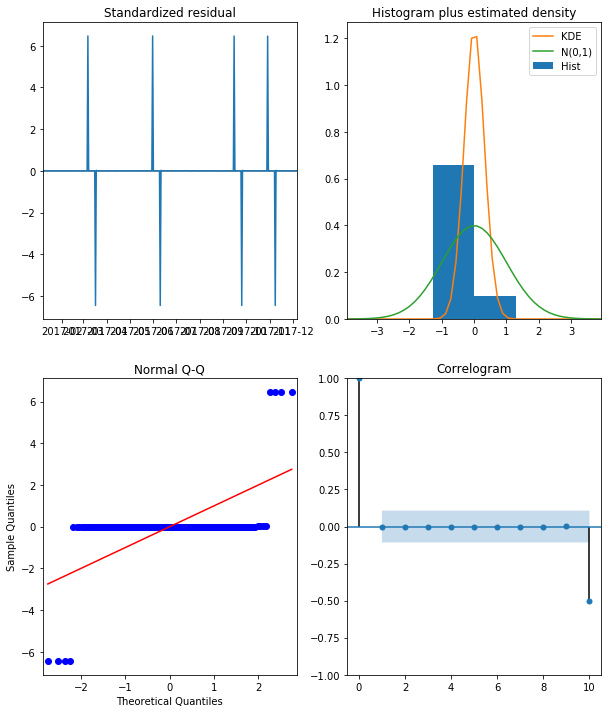

In [204]:
result5.plot_diagnostics(figsize=(10, 12))

In [205]:
plt.clf()
y_test5.shape

(83, 3)

In [206]:
y_pred5 = result5.get_prediction(start=train5+1, end=prod5_transformed.shape[0])
y_forecasted5 = y_pred5.predicted_mean
y_forecasted5.shape

(83, 3)

In [207]:
np.sqrt(mean_squared_error(y_pred=y_forecasted5, y_true=y_test5))

0.727916840285624

In [208]:
mean_absolute_error(y_pred=y_forecasted5, y_true=y_test5)

0.4122458961320125

## <font color=blue> 6. Mongodb ID: 5a92474635d6d32207bcd343 </font>

In [152]:
prod6 = genData('5a92474635d6d32207bcd343', conn, c, impute=True, freq='daily', standardize=False)
prod6.head()

,Sales,rating,ovsentiment
date,,,
2016-08-05,0,5.0,0.0
2016-08-06,1,3.0,0.0
2016-08-07,0,3.0,0.0
2016-08-08,0,5.0,1.0
2016-08-09,0,5.0,1.0


In [153]:
#prod6 = prod6[prod6['Sales'] != 0]
prod6.shape

(559, 3)

In [154]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['Sales'], '5a92474635d6d32207bcd343')
prod6Test.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-22.266279,Test Statistic
1,0.000000,p-value
2,0.000000,#Lags Used
3,558.000000,Number of Observations Used
4,-3.975086,Critical value for 1%
5,-3.418387,Critical value for 5%
6,-3.131696,Critical value for 10%


In [155]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['rating'], '5a92474635d6d32207bcd343')
prod6Test.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-8.004394e+00,Test Statistic
1,6.979865e-11,p-value
2,4.000000e+00,#Lags Used
3,5.540000e+02,Number of Observations Used
4,-3.975205e+00,Critical value for 1%
5,-3.418445e+00,Critical value for 5%
6,-3.131730e+00,Critical value for 10%


In [156]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['ovsentiment'], '5a92474635d6d32207bcd343')
prod6Test.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-2.513948,Test Statistic
1,0.321024,p-value
2,19.000000,#Lags Used
3,539.000000,Number of Observations Used
4,-3.975665,Critical value for 1%
5,-3.418667,Critical value for 5%
6,-3.131861,Critical value for 10%


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

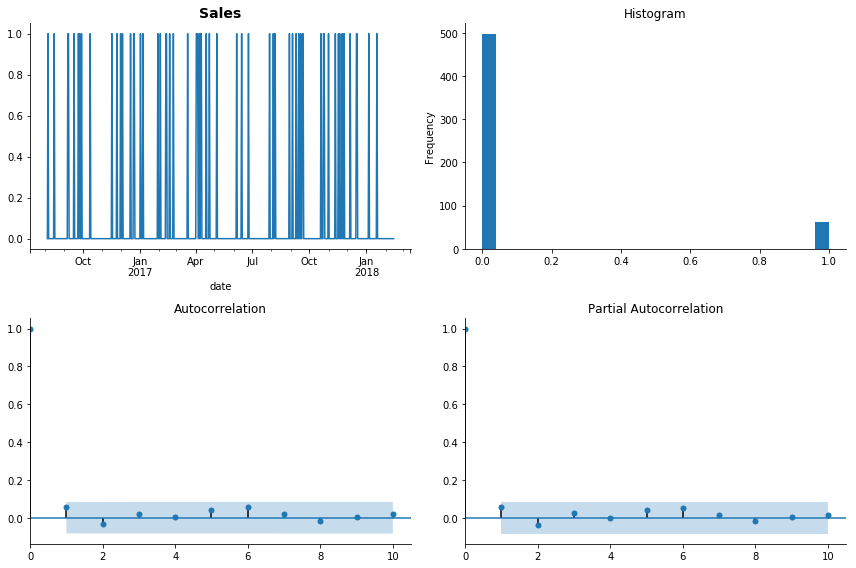

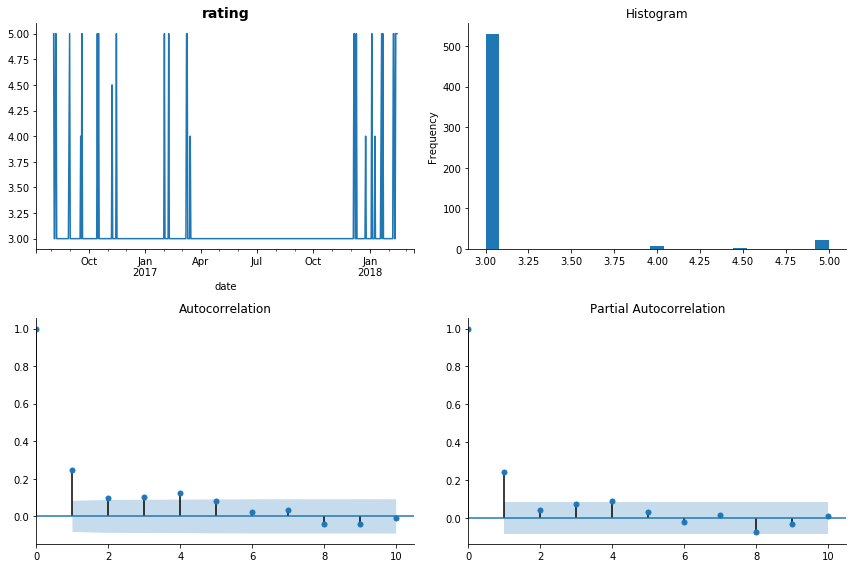

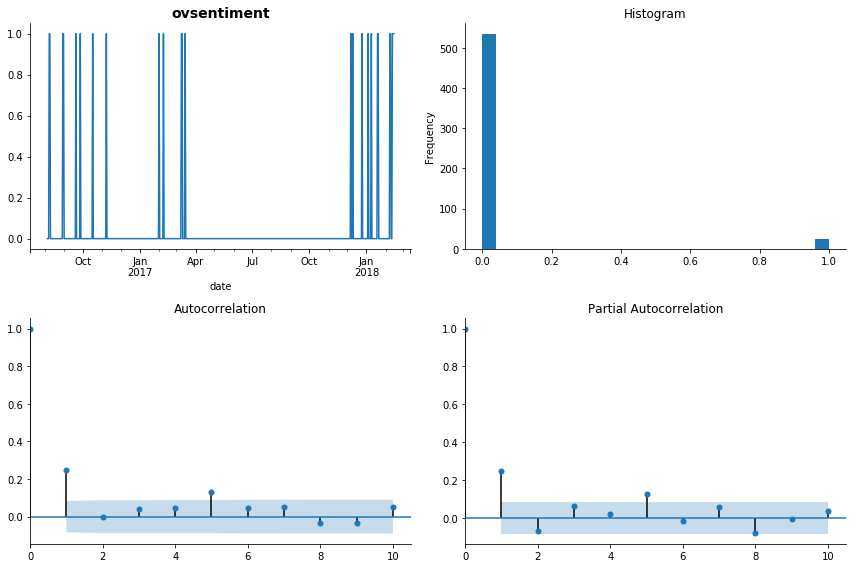

In [157]:
num_var6 = len(prod6.iloc[1, :])
for i in range(0, num_var6):
    tsplot(prod6.iloc[:, i].dropna(), title=prod6.columns[i], lags=10)
plt.show()

In [168]:
plt.clf()

In [158]:
prod6_transformed = prod6.copy()
#prod6_transformed['Sales'] = np.log(prod6_transformed['Sales'])
prod6_transformed['Sales'] = prod6_transformed['Sales'].diff(2)
prod6_transformed['rating'] = np.log(prod6_transformed['rating']).diff(1)
prod6_transformed['ovsentiment'] = prod6_transformed['ovsentiment'].diff(1)
prod6_transformed.dropna(inplace=True)

In [159]:
len(prod6_transformed.iloc[1, :])

3

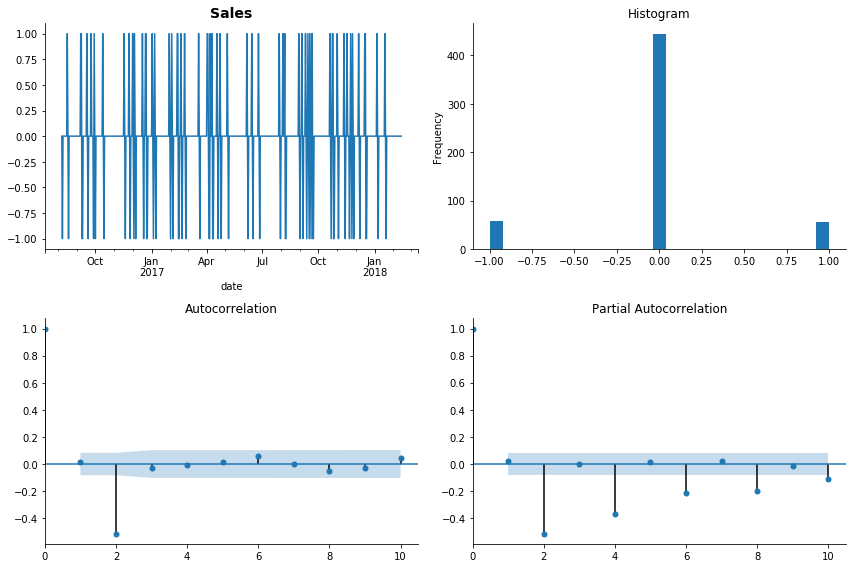

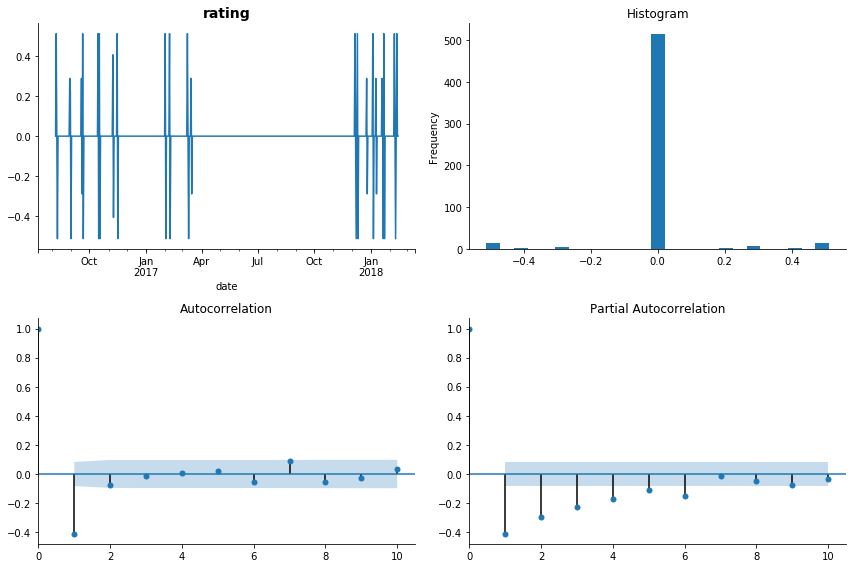

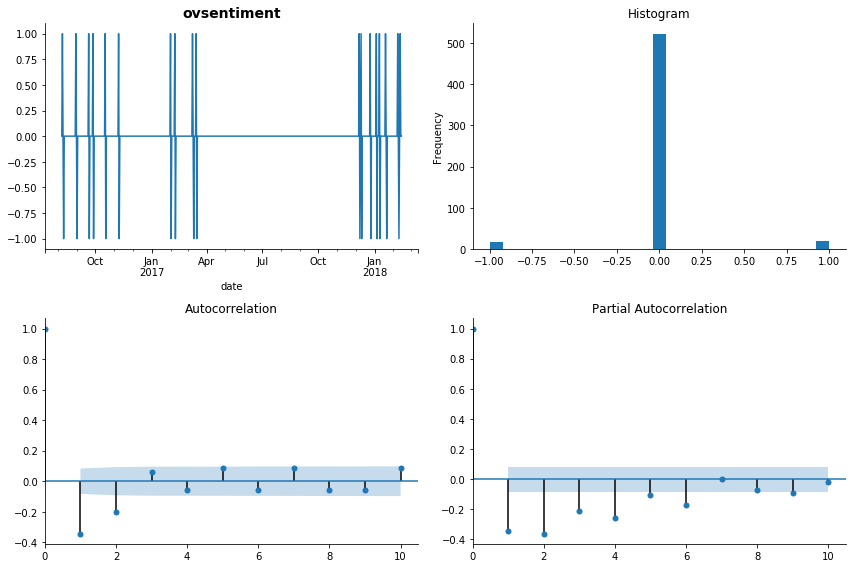

In [160]:
num_var6 = len(prod6_transformed.iloc[1, :])
for i in range(0, num_var6):
    tsplot(prod6_transformed.iloc[:, i].dropna(), title=prod6_transformed.columns[i], lags=10)
plt.show()

In [161]:
plt.clf()

In [162]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['Sales'].dropna(), '5a92474635d6d32207bcd343')
prod6_transformedTest.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-8.580472e+00,Test Statistic
1,3.278497e-12,p-value
2,1.900000e+01,#Lags Used
3,5.370000e+02,Number of Observations Used
4,-3.975728e+00,Critical value for 1%
5,-3.418697e+00,Critical value for 5%
6,-3.131879e+00,Critical value for 10%


In [163]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['rating'].dropna(), '5a92474635d6d32207bcd343')
prod6_transformedTest.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-8.591063e+00,Test Statistic
1,3.100175e-12,p-value
2,1.900000e+01,#Lags Used
3,5.370000e+02,Number of Observations Used
4,-3.975728e+00,Critical value for 1%
5,-3.418697e+00,Critical value for 5%
6,-3.131879e+00,Critical value for 10%


In [164]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['ovsentiment'].dropna(), '5a92474635d6d32207bcd343')
prod6_transformedTest.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-8.280799e+00,Test Statistic
1,1.604265e-11,p-value
2,1.900000e+01,#Lags Used
3,5.370000e+02,Number of Observations Used
4,-3.975728e+00,Critical value for 1%
5,-3.418697e+00,Critical value for 5%
6,-3.131879e+00,Critical value for 10%


In [165]:
# Train-Test Set Split
train6 = ceil(prod6.shape[0] * 0.9)
y_train6 = prod6[0:train6]
y_test6 = prod6[train6:]
y_train6.shape, y_test6.shape

((504, 3), (55, 3))

In [166]:
y_train6.dropna(inplace=True)
y_train6.dropna().shape

(504, 3)

In [167]:
BIC6 = detpq(y_train6, par=range(0,6))
BIC6.head()

,index,param,BIC
0,0,"(0, 1)",-133.742555
1,5,"(1, 0)",-133.067525
2,1,"(0, 2)",-95.457707
3,11,"(2, 0)",-92.139194
4,6,"(1, 1)",-77.274929


In [176]:
model6 = sm.tsa.VARMAX(y_train6, order=(0, 1))
result6 = model6.fit(maxiter=1000, disp=False)

result6.summary()

Dep. Variable:,"['Sales', 'rating', 'ovsentiment']",No. Observations:,504
Model:,VMA(1),Log Likelihood,122.941
,+ intercept,AIC,-209.882
Date:,"Tue, 10 Jul 2018",BIC,-133.876
Time:,18:52:11,HQIC,-180.067
Sample:,08-05-2016,,
,- 12-21-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"29.70, 46.45, 64.21",Jarque-Bera (JB):,"699.03, 13087.82, 56711.79"
Prob(Q):,"0.88, 0.22, 0.01",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.25, 0.35, 0.18",Skew:,"2.32, 4.81, -0.61"


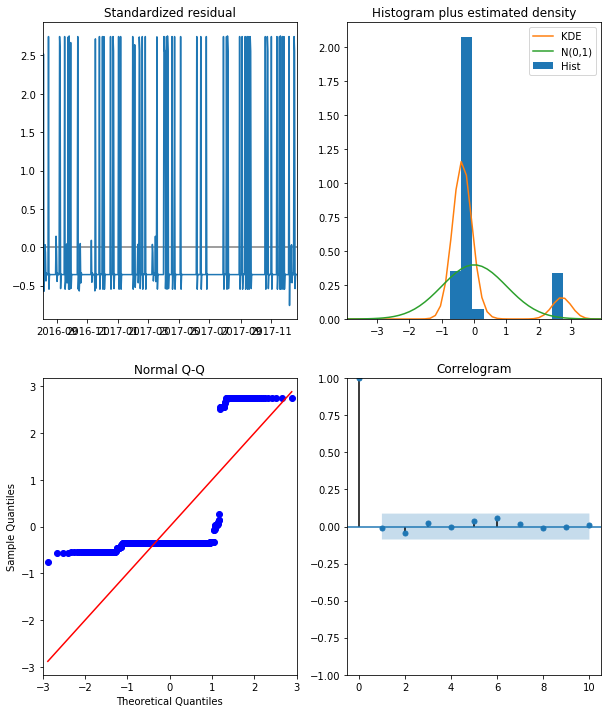

In [177]:
result6.plot_diagnostics(figsize=(10, 12))

In [178]:
plt.clf()
y_test6.shape

(55, 3)

In [179]:
y_pred6 = result6.get_prediction(start=train6+1, end=prod6.shape[0])
y_forecasted6 = y_pred6.predicted_mean
y_forecasted6.shape

(55, 3)

In [180]:
np.sqrt(mean_squared_error(y_pred=y_forecasted6, y_true=y_test6))

0.5187161364340601

In [181]:
mean_squared_error(y_pred=y_forecasted6, y_true=y_test6)

0.2690664301970785